In [33]:
# Reinforcement Learning Setup for Multi-Modal Transport (Gym-like Environment + Q-Learning)

import pandas as pd
import numpy as np
import random
from itertools import product
import gym
from gym import spaces
import matplotlib.pyplot as plt

In [34]:
# Load dataset
df = pd.read_excel("trainingtestingset_latest.xlsx")

In [35]:
# Format environment data per trip
env_data = []
segments = ['AB', 'BC', 'CD']
modes = ['taxi', 'bus', 'bike']

for _, row in df.iterrows():
    episode = {
        'traffic': {
            'AB': row['traffic_AB'],
            'BC': row['traffic_BC'],
            'CD': row['traffic_CD']
        },
        'travel_time': {
            'AB': {
                'taxi': row['taxi_AB'],
                'bus': row['bus_AB'],
                'bike': row['bike_AB']
            },
            'BC': {
                'taxi': row['taxi_BC'],
                'bus': row['bus_BC'],
                'bike': row['bike_BC']
            },
            'CD': {
                'taxi': row['taxi_CD'],
                'bus': row['bus_CD'],
                'bike': row['bike_CD']
            }
        }
    }
    env_data.append(episode)

In [36]:
# Define custom environment class
class TransportEnv(gym.Env):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.action_space = spaces.Discrete(3)  # taxi, bus, bike
        self.observation_space = spaces.MultiDiscrete([3, 4])  # segment index (0-2), traffic (1-3)
        self.reset()

    def reset(self):
        self.index = random.randint(0, len(self.data) - 1)
        self.segment = 0
        self.total_time = 0
        self.trip = self.data[self.index]
        return self._get_state()

    def _get_state(self):
        traffic_level = self.trip['traffic'][['AB', 'BC', 'CD'][self.segment]]
        return np.array([self.segment, traffic_level])

    def step(self, action):
        mode = modes[action]
        segment_key = segments[self.segment]
        time_cost = self.trip['travel_time'][segment_key][mode]

        reward = -time_cost
        self.total_time += time_cost

        self.segment += 1
        done = self.segment == 3
        next_state = self._get_state() if not done else np.array([0, 0])

        return next_state, reward, done, {}

    def render(self):
        print(f"Segment: {self.segment}, Total Time: {self.total_time}")

In [37]:
# Instantiate environment
env = TransportEnv(env_data)

In [38]:
# Q-learning parameters
q_table = np.zeros((3, 4, 3))  # (segment, traffic_level, action)
alpha = 0.1     # learning rate
gamma = 0.9     # discount factor
epsilon = 0.1   # exploration rate
episodes = 5000


In [39]:
# Training loop
for ep in range(episodes):
    state = env.reset()
    done = False

    while not done:
        seg, traffic = state
        if np.random.rand() < epsilon:
            action = np.random.randint(3)  # explore
        else:
            action = np.argmax(q_table[seg, traffic - 1])  # exploit

        next_state, reward, done, _ = env.step(action)

        next_seg, next_traffic = next_state if not done else (0, 0)
        old_value = q_table[seg, traffic - 1, action]
        next_max = np.max(q_table[next_seg, next_traffic - 1]) if not done else 0

        new_value = old_value + alpha * (reward + gamma * next_max - old_value)
        q_table[seg, traffic - 1, action] = new_value
        state = next_state

In [40]:
# Evaluate Q-learning policy
num_eval_episodes = 10
for ep in range(num_eval_episodes):
    state = env.reset()
    done = False
    total_time = 0
    print(f"\nEpisode {ep+1}")
    while not done:
        seg, traffic = state
        action = np.argmax(q_table[seg, traffic - 1])
        print(f"Segment {seg}: Traffic={traffic} → Action={modes[action]}")
        state, reward, done, _ = env.step(action)
        total_time += -reward
    print(f"Total Travel Time: {total_time:.2f} mins")



Episode 1
Segment 0: Traffic=3 → Action=taxi
Segment 1: Traffic=2 → Action=taxi
Segment 2: Traffic=1 → Action=taxi
Total Travel Time: 28.00 mins

Episode 2
Segment 0: Traffic=3 → Action=taxi
Segment 1: Traffic=1 → Action=taxi
Segment 2: Traffic=2 → Action=taxi
Total Travel Time: 37.00 mins

Episode 3
Segment 0: Traffic=1 → Action=taxi
Segment 1: Traffic=3 → Action=taxi
Segment 2: Traffic=1 → Action=taxi
Total Travel Time: 42.00 mins

Episode 4
Segment 0: Traffic=3 → Action=taxi
Segment 1: Traffic=2 → Action=taxi
Segment 2: Traffic=2 → Action=taxi
Total Travel Time: 32.00 mins

Episode 5
Segment 0: Traffic=1 → Action=taxi
Segment 1: Traffic=2 → Action=taxi
Segment 2: Traffic=1 → Action=taxi
Total Travel Time: 28.00 mins

Episode 6
Segment 0: Traffic=1 → Action=taxi
Segment 1: Traffic=2 → Action=taxi
Segment 2: Traffic=3 → Action=taxi
Total Travel Time: 28.00 mins

Episode 7
Segment 0: Traffic=2 → Action=taxi
Segment 1: Traffic=1 → Action=taxi
Segment 2: Traffic=3 → Action=taxi
Total Tr

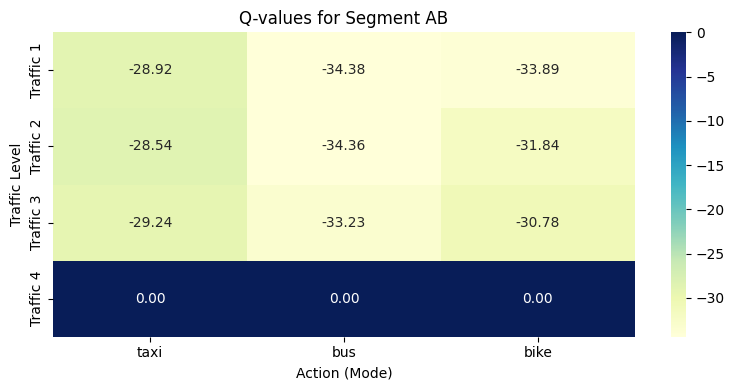

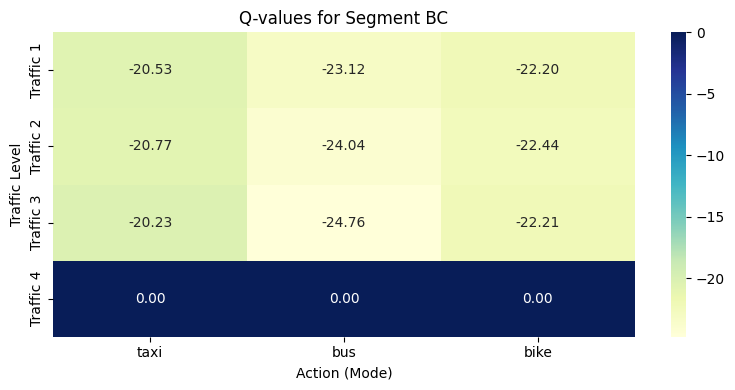

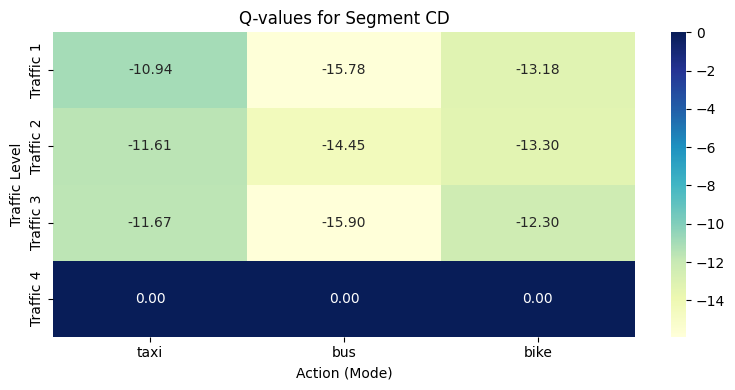

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Q-values per segment
for seg in range(3):
    plt.figure(figsize=(8, 4))
    sns.heatmap(q_table[seg], annot=True, fmt=".2f",
                xticklabels=modes,
                yticklabels=[f"Traffic {i}" for i in range(1, 5)],
                cmap="YlGnBu")
    plt.title(f"Q-values for Segment {segments[seg]}")
    plt.xlabel("Action (Mode)")
    plt.ylabel("Traffic Level")
    plt.tight_layout()
    plt.show()


In [42]:
print("Learned Policy (Best Mode per Segment and Traffic):")
for seg in range(3):
    print(f"\nSegment {segments[seg]}:")
    for traffic in range(1, 5):
        best_action = np.argmax(q_table[seg, traffic - 1])
        print(f"  Traffic {traffic}: {modes[best_action]}")


Learned Policy (Best Mode per Segment and Traffic):

Segment AB:
  Traffic 1: taxi
  Traffic 2: taxi
  Traffic 3: taxi
  Traffic 4: taxi

Segment BC:
  Traffic 1: taxi
  Traffic 2: taxi
  Traffic 3: taxi
  Traffic 4: taxi

Segment CD:
  Traffic 1: taxi
  Traffic 2: taxi
  Traffic 3: taxi
  Traffic 4: taxi
